<a href="https://colab.research.google.com/github/2kunal6/UniBonn/blob/master/cuda_lab/2/Assignment2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Files already downloaded and verified
Files already downloaded and verified


  1%|          | 14/1407 [00:00<00:10, 135.49it/s]

datasets loaded
Running on the GPU


  1%|          | 16/1407 [00:00<00:09, 152.30it/s]

epoch: 0, loss: 2.443737030029297


100%|██████████| 1407/1407 [00:21<00:00, 65.71it/s]


epoch: 1, loss: 1.754233717918396
[3200, 6400, 9600, 12800, 16000, 19200, 22400, 25600, 28800, 32000, 35200, 38400, 41600, 44800, 48000, 51200, 54400, 57600, 60800, 64000, 67200, 70400, 73600, 76800, 80000, 83200, 86400, 89600]
[tensor(2.1917, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.2518, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0074, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9739, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9502, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1483, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0281, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1716, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.8889, device='cuda:0', grad_fn=<NllLossBackward>), tensor(1.9466, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1439, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.0548, device='cuda:0', grad_fn=<NllLossBackward>), tensor(2.1712, device='cuda:0', grad_fn=<NllLossBac

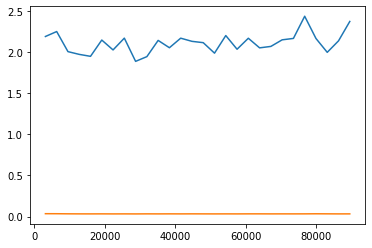

[[103  41 228   3 219  55  99   2  90 160]
 [  9  91  24   4  73  47 151   3  43 555]
 [ 53  48 178  10 286 151 174   2  27  71]
 [ 15  59  86  11 162 289 226   2  40 110]
 [ 25  37 102   4 294 171 267   3  34  63]
 [ 16  46  93  11 152 406 168   2  49  57]
 [  9 121  47  22 176 176 321   1  12 115]
 [ 34  32 139   7 278 112 206   1  55 136]
 [ 70  36  57   5  76 151  51   1 195 358]
 [ 17  65  24   2  66  30 122   0  60 614]]
Accuracy of the network on the 10000 test images: 22.14


In [16]:
import torch
import torchvision
from torchvision import datasets, transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim

import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

np.random.seed(1)

transform_list = transforms.Compose([
            transforms.Grayscale(num_output_channels=1),
            transforms.ToTensor()
            #transforms.Normalize([0.5,],[0.5,])
        ])
train = datasets.CIFAR10("./", train=True, transform=transform_list, download=True)

test = torch.utils.data.DataLoader(
    datasets.CIFAR10("./", train=False, transform=transform_list, download=True), batch_size = 32, shuffle = True
)

print("datasets loaded")

IMG_SIZE = 32*32

'''for data in train:
  X, y = data[0][0], data[1][0]
  plt.imshow(X.view(32, 32))
  print("Label: " + str(y))
  plt.show()
  break'''

class LogisticRegression(nn.Module):
  def __init__(self, input_dim, output_dim):
    super(LogisticRegression, self).__init__()
    self.linear1 = nn.Linear(input_dim, 300)
    self.linear2 = nn.Linear(300, output_dim)
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.relu(self.linear1(x))
    out = self.linear2(out)
    return out

if torch.cuda.is_available():
    device = torch.device("cuda:0")  # you can continue going on here, like cuda:1 cuda:2....etc. 
    print("Running on the GPU")
else:
    device = torch.device("cpu")
    print("Running on the CPU")

model = LogisticRegression(IMG_SIZE, 10).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

criterion = nn.CrossEntropyLoss().to(device)

def test_perform(test_data):
  total = 0
  correct = 0

  y_true = []
  y_pred = []

  loss = 0.0
  with torch.no_grad():
    for data in test_data:
      X, y = data[0].to(device), data[1].to(device)

      output = model(X.view(-1, IMG_SIZE))
      _, predicted = torch.max(output, 1)

      loss += criterion(output, y)

      total += y.size(0)
      correct += (predicted == y).sum().item()

      y_pred.extend(predicted.tolist())
      y_true.extend(y.tolist())

    accuracy = 100 * correct / total
    return accuracy, y_true, y_pred, loss/(2.0 * total)

BATCH_SIZE = 32

loss_train = []
loss_val = []
iter_list = []
iter_num = 0

for epoch in range(2):
  train_size = int(0.9 * len(train))
  val_size = len(train) - train_size
  train_dataset, val_dataset = torch.utils.data.random_split(train, [train_size, val_size])
  train_loader = torch.utils.data.DataLoader(train_dataset,batch_size = BATCH_SIZE, shuffle = True)
  val_loader = torch.utils.data.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True)

  for data in tqdm(train_loader):
    X, y = data[0].to(device), data[1].to(device)
    
    optimizer.zero_grad()
    
    output = model(X.view(-1, IMG_SIZE))
    
    loss = criterion(output, y)
    
    loss.backward()
    
    optimizer.step()
    
    iter_num+=BATCH_SIZE

    if(iter_num%(BATCH_SIZE*100) == 0):
      _, _, _, val_loss = test_perform(val_loader)

      iter_list.append(iter_num)
      loss_train.append(loss)
      loss_val.append(val_loss)

    
  print(f'epoch: {epoch}, loss: {loss}')

plt.plot(iter_list, loss_train)
plt.plot(iter_list, loss_val)
plt.show()

    
accuracy, y_true, y_pred, _ = test_perform(test)

print(confusion_matrix(y_true, y_pred))
print(f'Accuracy of the network on the 10000 test images: {accuracy}')